# G3 Processing

This file contains code to view and load G3 files produced by ``g3_packager``.

To run this Jupyter notebook on the CCAT Control Computer, see [``HOWTORUN.md``](./HOWTORUN.md).

## G3 File Analysis

In [11]:
import numpy as np
import os
import g3utils as ut
import matplotlib.pyplot as plt
from spt3g import core

In [3]:
control_computer_g3_dir = "/media/player1/blast2020fc1/blasttng_g3"
path_to_file = "testing/roach1_pass3.g3"
filename = os.path.join(control_computer_g3_dir, path_to_file)

### File Content Overview

In [3]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.FrameCounter)
pipe.Run()


Calibration
PipelineInfo
Scan (x117)
EndProcessing


### File Content Full Dump

In [4]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(core.Dump)
pipe.Run()

Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
]
Frame (PipelineInfo) [
"04-Apr-2025:19:40:14.836693000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"07-Apr-2025:18:36:13.717662000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:19:40:14.835471000
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 sa

### Scan Frames

In [5]:
first_scan_grabber = ut.FirstFrameGrabber(core.G3FrameType.Scan)
last_scan_grabber = ut.LastFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(first_scan_grabber)
pipe.Add(last_scan_grabber)
pipe.Run()

first_scan_frame = first_scan_grabber.first_frame
last_scan_frame = last_scan_grabber.last_frame

print("\nFirst Scan Frame: ", first_scan_frame)
print("\nLast Scan Frame: ", last_scan_frame)

Found the first frame with type: Scan!
The frame is now stored in <g3utils.FirstFrameGrabber object at 0x7f54218a2d40>'s first_frame attribute.
Found the last frame with type: Scan!
The frame is now stored in <g3utils.LastFrameGrabber object at 0x7f54218a3490>'s last_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:19:40:14.835471000
]

Last Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"az" (spt3g.core.G3Timestream) => 935 samples at 473.1 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 935)
"el" (spt3g.core.G3Timestream) => 935 sam

### Calibration Frame

In [6]:
calframe_grabber = ut.FirstFrameGrabber(core.G3FrameType.Calibration)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(calframe_grabber)
pipe.Run()

cal_frame = calframe_grabber.first_frame

print("\nCalibration Frame: ", cal_frame)

Found the first frame with type: Calibration!
The frame is now stored in <g3utils.FirstFrameGrabber object at 0x7f54218a3d90>'s first_frame attribute.

Calibration Frame:  Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
]


In [7]:
# Here is how to load targ_sweeps info for DF calculation

If_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_I"])
Qf_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_Q"])
Ff_0000 = np.array(cal_frame["target_sweeps"]["roach1_0000_F"])

for name, arr in zip(("If", "Qf", "Ff"), (If_0000, Qf_0000, Ff_0000)):
    print(f"{name}.shape: ", arr.shape)

# If, Qf, and Ff are required inputs to df_IQangle, in addition to the KID I/Q data

If.shape:  (176,)
Qf.shape:  (176,)
Ff.shape:  (176,)


### RA/DEC Computation

We can now compute RA/DEC from the stored information, add "ra" and "dec" as keys in the scan frame, and save the result of the pipeline to a new file.

In [4]:
radec_file = os.path.join(control_computer_g3_dir, "testing/add_radec.g3")

In [9]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(ut.add_radec)
pipe.Add(core.G3Writer, filename=radec_file)
pipe.Run(profile=True)

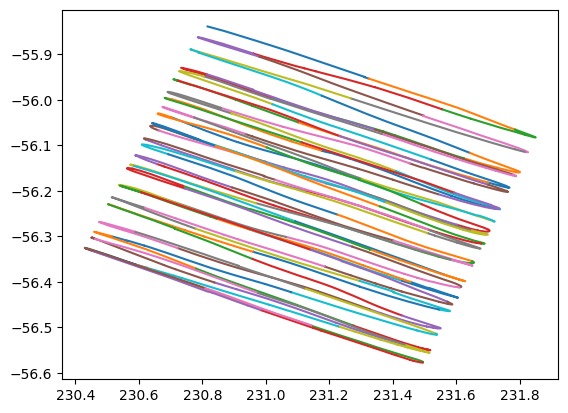

In [10]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(ut.plot_ra_dec)
pipe.Run()

### DF Calculation

#### Single Detector

In [5]:
single_df_file = os.path.join(control_computer_g3_dir, "testing/add_single_df.g3")

In [12]:
pipe = core.G3Pipeline()

pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(ut.AddSingleKidDF, roach_id=1, kid="0000")
pipe.Add(core.Dump)
pipe.Add(core.G3Writer, filename=single_df_file)

pipe.Run()

Frame (Calibration) [
"target_sweeps" (spt3g.core.G3TimestreamMap) => Timestreams from 1143 detectors
]
Frame (PipelineInfo) [
"04-Apr-2025:19:40:14.836693000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"07-Apr-2025:18:36:14.279986000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"07-Apr-2025:18:36:55.903811000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"ra" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"roach1_0000_DF" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.co

In [13]:
scan_frame_grabber = ut.FirstFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=single_df_file)
pipe.Add(scan_frame_grabber)
pipe.Run()

first_scan_frame = scan_frame_grabber.first_frame

print("\nFirst Scan Frame: ", first_scan_frame)

Found the first frame with type: Scan!
The frame is now stored in <g3utils.FirstFrameGrabber object at 0x7f541d387c40>'s first_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"ra" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"roach1_0000_DF" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:19:40:14.835471000
]


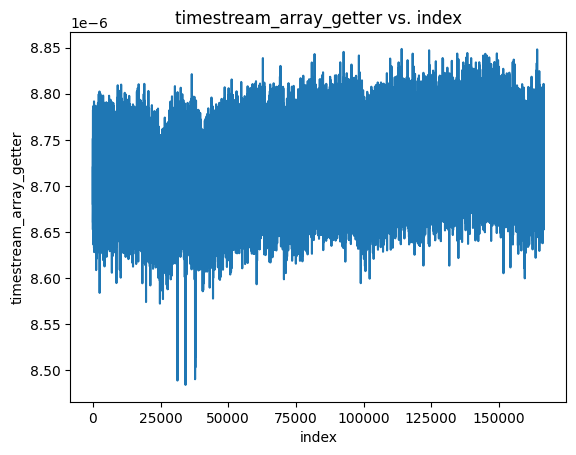

In [14]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=single_df_file)
pipe.Add(ut.TimeStreamPlotter, ts_key="roach1_0000_DF")
pipe.Run()

#### All Detectors

In [6]:
all_df_file = os.path.join(control_computer_g3_dir, "testing/add_all_df.g3")

In [16]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(ut.AddAllDF, roach_id=1)
pipe.Add(ut.FrameCounter)
pipe.Add(core.G3Writer, filename=all_df_file)
pipe.Run()


Calibration
PipelineInfo
Scan (x117)
EndProcessing


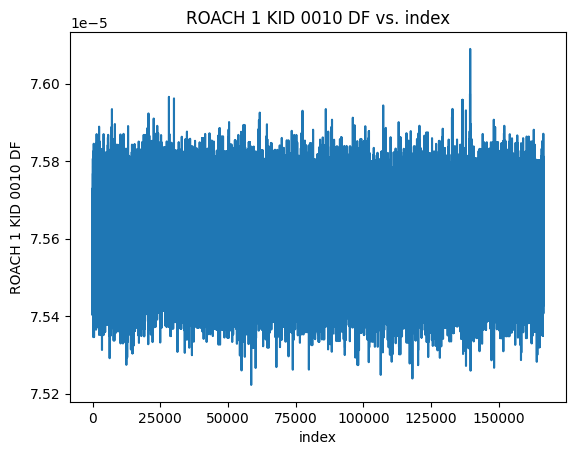

In [17]:
pipe = core.G3Pipeline()

def kid_df_getter(kid: str):
    def get_selected_kid_df(frame):
        kid_key = f"roach1_{kid}"
        super_ts = frame["df"]
        kid_idx = int(np.where(np.array(super_ts.names) == kid_key)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_selected_kid_df

kid_to_plot = "0010"
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(ut.GenericPlotter, array_getter=kid_df_getter(kid_to_plot), label=f"ROACH 1 KID {kid_to_plot} DF")
pipe.Run()

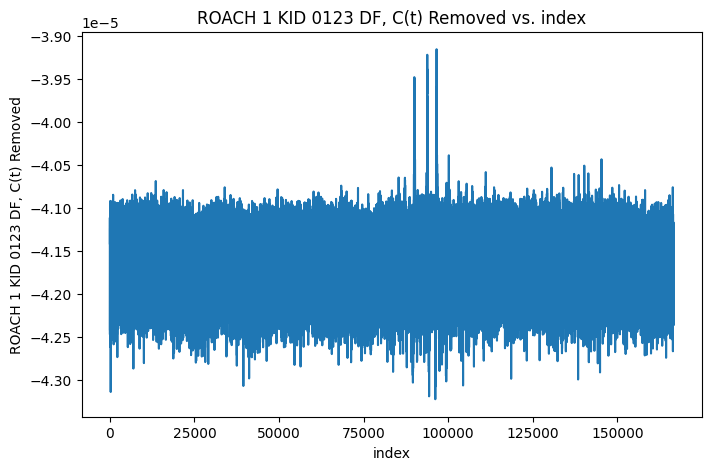

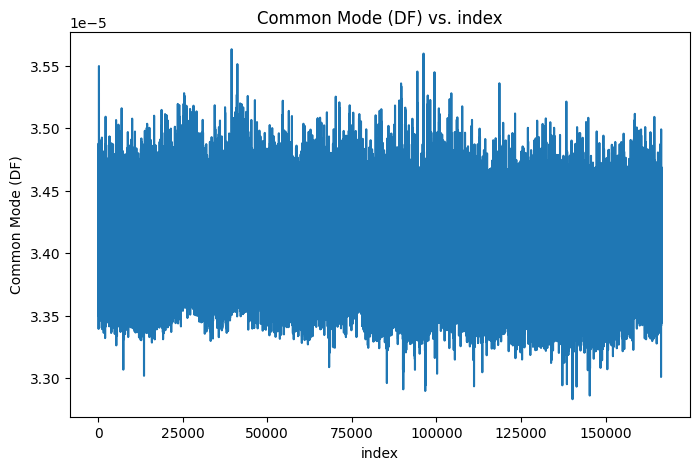

In [7]:
pipe = core.G3Pipeline()

def kid_df_ctremoved_getter(kid: str):
    def get_selected_kid_df(frame):
        kid_key = f"roach1_{kid}"
        super_ts = frame["df_ctremoved"]
        kid_idx = int(np.where(np.array(super_ts.names) == kid_key)[0][0])
        return np.array(super_ts.data[kid_idx])
    return get_selected_kid_df

kid_to_plot = "0123"
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(ut.remove_common_mode)  # naive: non-normalized DF, no weights...
pipe.Add(ut.GenericPlotter,
         array_getter=kid_df_ctremoved_getter(kid_to_plot),
         label=f"ROACH 1 KID {kid_to_plot} DF, C(t) Removed",
         subplots_args={"figsize": (8, 5)})
pipe.Add(ut.TimeStreamPlotter,
         label=f"Common Mode (DF)",
         ts_key="common_mode",
         subplots_args={"figsize": (8, 5)})
pipe.Run()

In [263]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

# map dimensions
xlen = 1.4 * core.G3Units.deg
ylen = 0.9 * core.G3Units.deg

# pixel resolution
res = 1.5 * core.G3Units.arcmin

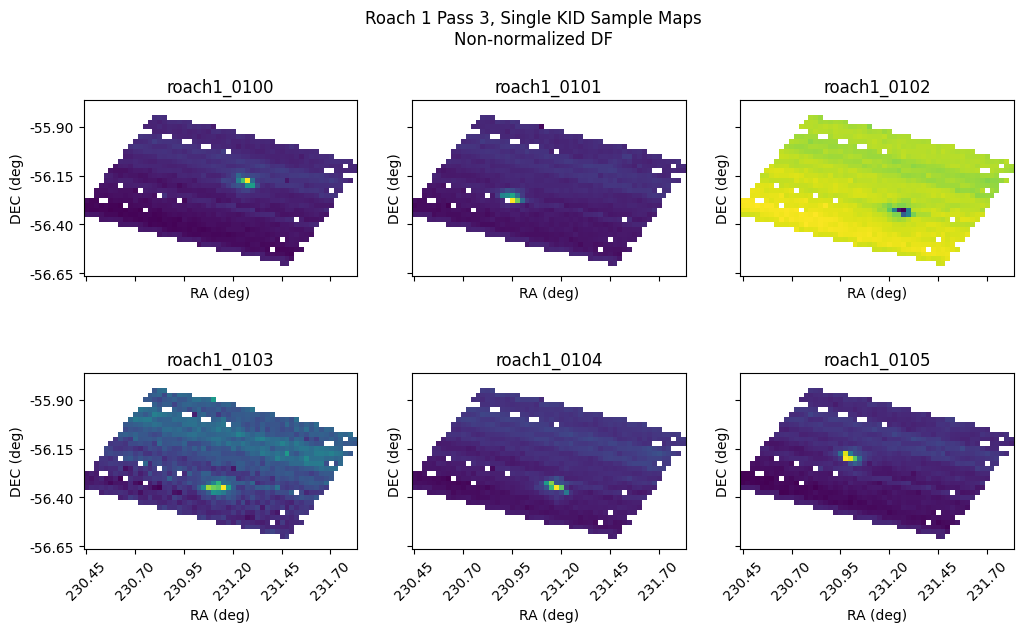

In [265]:
# instantiate binners
binners = [ut.SingleMapBinner(kid=f"roach1_0{i:03}", timestreams="df", ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res)
           for i in range(100, 106)]

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(ut.remove_common_mode)
for binner in binners:
    pipe.Add(binner)
pipe.Run()

fig, axs = plt.subplots(2, 3, figsize=(12, 6.5), sharex='all', sharey='all')
fig.suptitle("Roach 1 Pass 3, Single KID Sample Maps"
            "\nNon-normalized DF")

for binner, ax in zip(binners, axs.flat):
    binner.plot(ax=ax)
plt.show()

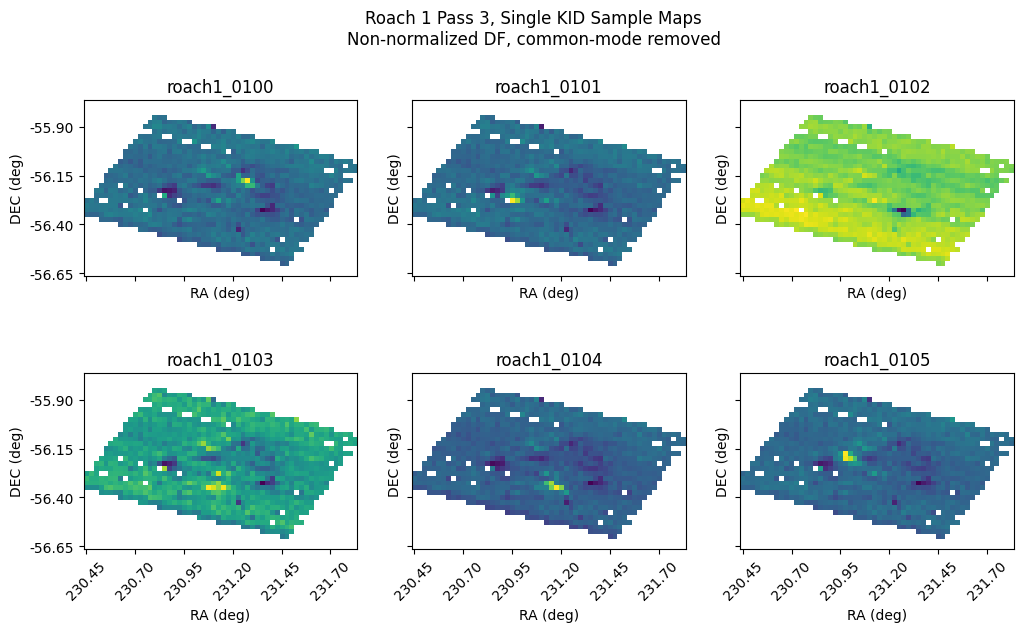

In [267]:
# instantiate binners
binners = [SingleMapBinner(kid=f"roach1_0{i:03}", timestreams="df_ctremoved") for i in range(100, 106)]

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=all_df_file)
pipe.Add(ut.remove_common_mode)
for binner in binners:
    pipe.Add(binner)
pipe.Run()

fig, axs = plt.subplots(2, 3, figsize=(12, 6.5), sharex='all', sharey='all')
fig.suptitle("Roach 1 Pass 3, Single KID Sample Maps"
            "\nNon-normalized DF, common-mode removed")

for binner, ax in zip(binners, axs.flat):
    binner.plot(ax=ax)
plt.show()